In [1]:
import torch
import sklearn

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import datasets
from sklearn.neighbors import KernelDensity

from sliceduot.sliced_uot import unbalanced_sliced_ot, sliced_unbalanced_ot, project_support

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


# Dataset

In [3]:
get_rot= lambda theta : np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta),np.cos(theta)]])

# regular distribution of Gaussians around a circle
def make_blobs_reg(n_samples, n_blobs, scale=.5):
  per_blob=int(n_samples/n_blobs)
  result = np.random.randn(per_blob,2) * scale + 5
  theta=(2*np.pi)/(n_blobs)
  for r in range(1,n_blobs):
    new_blob=(np.random.randn(per_blob,2) * scale + 5).dot(get_rot(theta*r))
    result = np.vstack((result,new_blob))
  return result

# random MoG
def make_blobs_random(n_samples, n_blobs, scale=.5, offset=3):
  per_blob=int(n_samples/n_blobs)
  result = np.random.randn(per_blob,2) * scale + np.random.randn(1,2)*offset
  for r in range(1,n_blobs):
    new_blob=np.random.randn(per_blob,2) * scale + np.random.randn(1,2)*offset
    result = np.vstack((result,new_blob))
  return result

#%%
def make_spiral(n_samples, noise=.5):
    n = np.sqrt(np.random.rand(n_samples,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_samples,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_samples,1) * noise
    return np.array(np.hstack((d1x,d1y)))
   
n_samples=500
expe='outlier'

if expe=='spirals':
  r=2.5
  Xs = make_spiral(n_samples=n_samples, noise=1)
  Xt = make_spiral(n_samples=n_samples, noise=1).dot(get_rot(r))
  y = np.hstack(([0]*n_samples,[1]*n_samples))
  X = np.vstack((Xs,Xt))
elif expe=='mog_reg':
  r=.5
  Xs = make_blobs_reg(n_samples=n_samples, n_blobs=2)
  Xt = make_blobs_reg(n_samples=n_samples, n_blobs=3).dot(get_rot(r))
  y = np.hstack(([0]*Xs.shape[0],[1]*Xt.shape[0]))
  X = np.vstack((Xs,Xt))
elif expe=='mog_random':
  Xs = make_blobs_random(n_samples=n_samples, scale=.3,n_blobs=4)
  Xt = make_blobs_random(n_samples=n_samples, scale=.3,n_blobs=4)
  y = np.hstack(([0]*n_samples,[1]*n_samples))
  X = np.vstack((Xs,Xt))
elif expe=='custom':
  Xs = make_blobs_random(n_samples=n_samples, scale=.3,n_blobs=1,offset=0)-6
  Xt = make_spiral(n_samples=n_samples, noise=1)
  y = np.hstack(([0]*n_samples,[1]*n_samples))
  X = np.vstack((Xs,Xt))
elif expe=='outlier':
  nb_outliers = 200
  Xs = make_blobs_random(n_samples=n_samples, scale=.2,n_blobs=1,offset=0)-.5
  Xs_outlier = make_blobs_random(n_samples=nb_outliers, scale=.05,n_blobs=1,offset=0)-[2,0.5]
  Xs = np.vstack((Xs,Xs_outlier)) 
  Xt = make_blobs_random(n_samples=n_samples, scale=.2,n_blobs=1,offset=0)+1.5
  y = np.hstack(([0]*(n_samples+nb_outliers),[1]*n_samples))
  X = np.vstack((Xs,Xt))  
elif expe=='two_moons':
  X, y = sklearn.datasets.make_moons(n_samples=n_samples, noise=0.05)
  Xs = X[y==0,:]
  Xt = X[y==1,:]

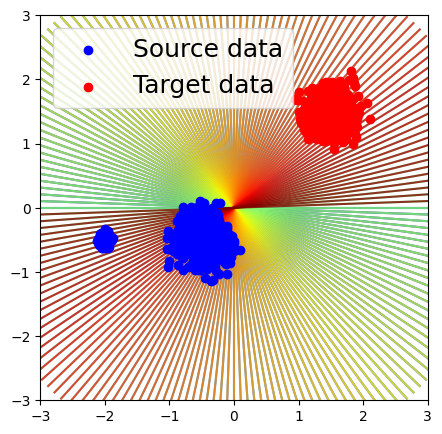

In [4]:
nb_slices = 180
offset_degree = 2*np.pi/nb_slices
colors = plt.cm.jet(np.linspace(0,1,nb_slices))

X1 = np.array([-4,0])
X2 = np.array([4,0])

plt.figure(figsize=(5,5))

for i in range(nb_slices):
    R = get_rot(offset_degree*i)
    X1_r = X1.dot(R)
    X2_r = X2.dot(R)
    plt.plot([X1_r[0],X2_r[0]],[X1_r[1],X2_r[1]],color=colors[i],alpha=.8, zorder=0)
plt.scatter(Xs[:,0],Xs[:,1], zorder=1,c='b',label='Source data')
plt.scatter(Xt[:,0],Xt[:,1], zorder=1,c='r',label='Target data')
plt.xlim([-3,3])
plt.ylim([-3,3])
#plt.axis('off')
plt.legend(loc='best',fontsize=18)
plt.show()

# expe. Compare SUOT / USOT on slices


In [5]:
def kde_sklearn(x, x_grid, weights=None, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    if weights is not None:
      kde_skl.fit(x[:, np.newaxis], sample_weight=weights)
    else:
      kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

In [26]:
Xs_torch = torch.from_numpy(Xs).type(torch.float).to(device)
Xt_torch = torch.from_numpy(Xt).type(torch.float).to(device)

p=2
num_proj=180

a = torch.ones(Xs.shape[0],dtype=torch.float, device=device) #/ Xs.shape[0]
b = torch.ones(Xt.shape[0],dtype=torch.float, device=device) #/ Xt.shape[0]

# construct projections
thetas = np.linspace(0, np.pi, num_proj)
dir = np.array([(np.cos(theta),np.sin(theta)) for theta in thetas])
dir_torch=torch.from_numpy(dir).type(torch.float).to(device)

rho1_USOT=0.0055
rho2_USOT=1
_, _, _, A_USOT, B_USOT, _ = unbalanced_sliced_ot(a, b, Xs_torch, Xt_torch, p, num_proj, rho1_USOT, rho2_USOT, niter=10, projections=dir_torch.T)

rho1_SUOT=.01
rho2_SUOT=1
_, _, _, A_SUOT, B_SUOT, _, = sliced_unbalanced_ot(a, b, Xs_torch, Xt_torch, p, num_proj, rho1_SUOT, rho2_SUOT, niter=10, projections=dir_torch.T)

Xps, Xpt = project_support(Xs_torch, Xt_torch, dir_torch.T)

/opt/conda/lib/python3.12/site-packages/sklearn/neighbors/_kde.py:272: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(
/opt/conda/lib/python3.12/site-packages/sklearn/neighbors/_kde.py:272: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(
/opt/conda/lib/python3.12/site-packages/sklearn/neighbors/_kde.py:272: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(
/opt/conda/lib/python3.12/site-packages/sklearn/neighbors/_kde.py:272: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(
/opt/conda/lib/python3.12/site-packages/sklearn/neighbors/_kde.py:272: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(
/opt/conda/lib/python3.12/site-packages/sklearn/neighbors/_kde.py:272: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(


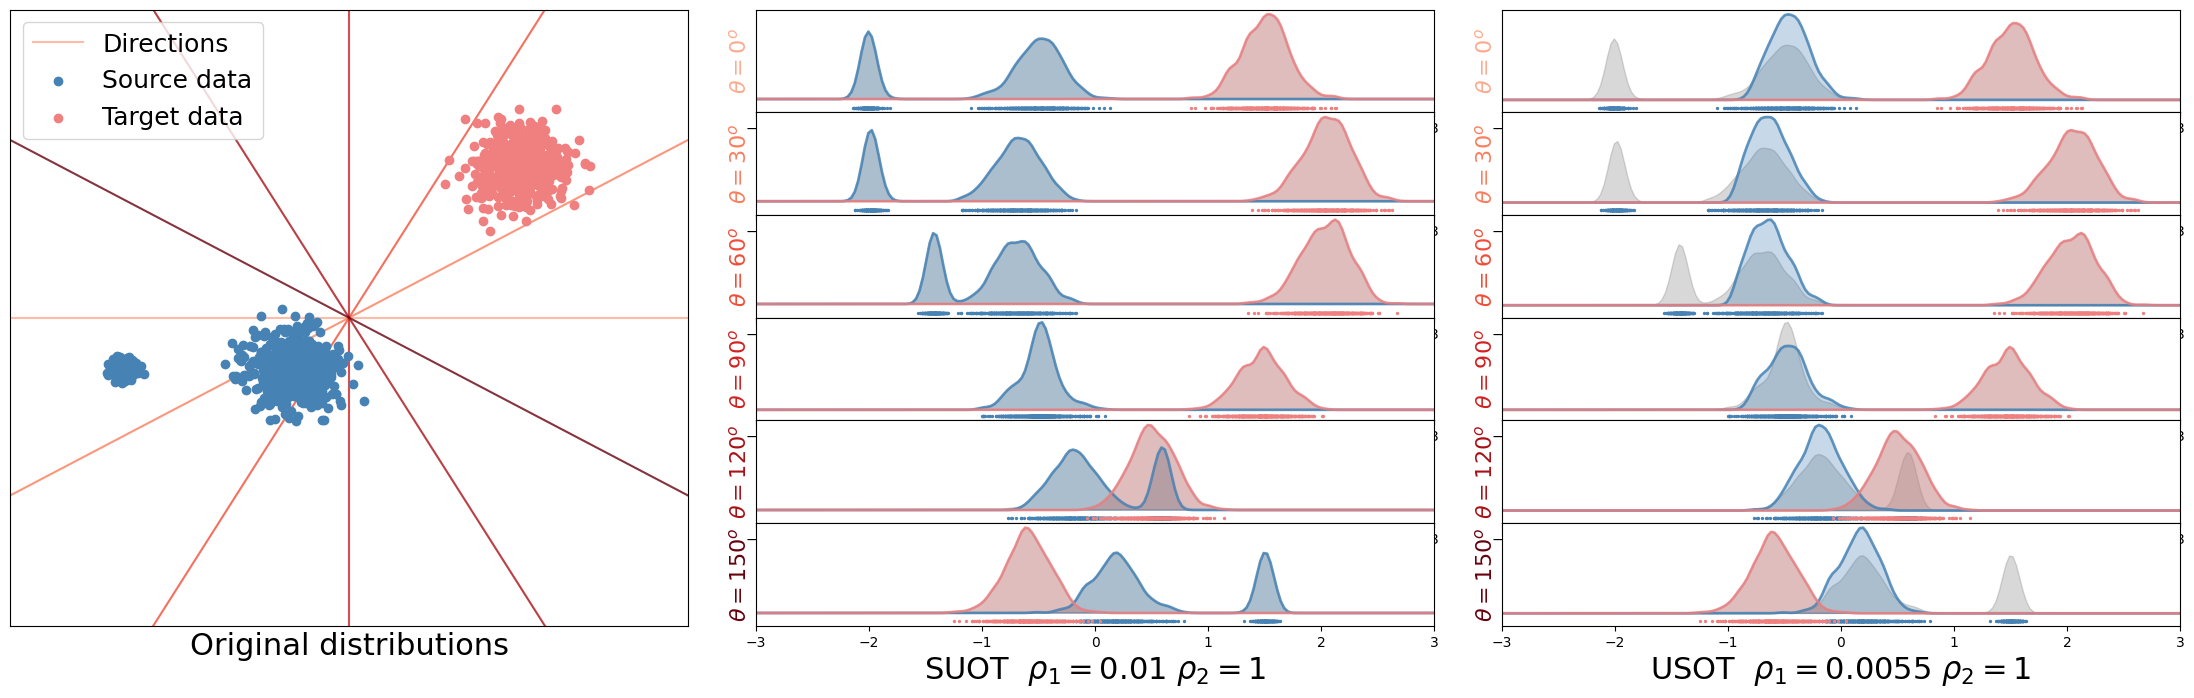

In [27]:
c1 = np.array(mpl.colors.to_rgb('lightcoral'))
c2 = np.array(mpl.colors.to_rgb('steelblue'))

# define ploting grid
xlim_min = -3
xlim_max = 3
x_grid = np.linspace(xlim_min,xlim_max,200)
bw = 0.05

# visu parameters
nb_slices = 6
offset_degree = int(180/nb_slices)

delta_degree = np.pi/nb_slices
colors = plt.cm.Reds(np.linspace(0.3,1,nb_slices))

X1 = np.array([-4,0])
X2 = np.array([4,0])

fig = plt.figure(figsize=(28,8))
ax1 = plt.subplot2grid((nb_slices,3),(0, 0), rowspan=nb_slices)



for i in range(nb_slices):
    R = get_rot(delta_degree*(-i))
    X1_r = X1.dot(R)
    X2_r = X2.dot(R)
    if i==0:
        ax1.plot([X1_r[0],X2_r[0]],[X1_r[1],X2_r[1]],color=colors[i],alpha=.8, zorder=0,label='Directions')
    else:
        ax1.plot([X1_r[0],X2_r[0]],[X1_r[1],X2_r[1]],color=colors[i],alpha=.8, zorder=0)
ax1.scatter(Xs[:,0],Xs[:,1], zorder=1,color=c2,label='Source data')
ax1.scatter(Xt[:,0],Xt[:,1], zorder=1,color=c1,label='Target data')
ax1.set_xlim([-3,3])
ax1.set_ylim([-3,3])
ax1.set_yticks([])
ax1.set_xticks([])
ax1.legend(loc='best',fontsize=18)
ax1.set_xlabel('Original distributions',fontsize=22)

#***** plot SUOT
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0.1)

for i in range(nb_slices):
    ax = plt.subplot2grid((nb_slices,3),(i, 1))
    weights_src = A_SUOT[i*offset_degree,:].cpu().numpy()
    weights_tgt = B_SUOT[i*offset_degree,:].cpu().numpy()
    samples_src = Xps[i*offset_degree,:].cpu().numpy()
    samples_tgt = Xpt[i*offset_degree,:].cpu().numpy()
    pdf_source = kde_sklearn(samples_src, x_grid, weights=weights_src, bandwidth=bw)
    pdf_target = kde_sklearn(samples_tgt, x_grid, weights=weights_tgt,  bandwidth=bw)
    pdf_source_without_w = kde_sklearn(samples_src, x_grid, bandwidth=bw)
    pdf_target_without_w = kde_sklearn(samples_tgt, x_grid,  bandwidth=bw)

    ax.scatter(samples_src,[-.2]*samples_src.shape[0],color=c2,s=2)
    ax.plot(x_grid, pdf_source, color=c2, alpha=0.8, lw=2)
    ax.fill(x_grid, pdf_source_without_w, ec='grey', fc='grey', alpha=0.3)
    ax.fill(x_grid, pdf_source, ec=c2, fc=c2, alpha=0.3)

    ax.scatter(samples_tgt,[-.2]*samples_tgt.shape[0],color=c1,s=2)
    ax.plot(x_grid, pdf_target, color=c1, alpha=0.8, lw=2)
    ax.fill(x_grid, pdf_target_without_w, ec='grey', fc='grey', alpha=0.3)
    ax.fill(x_grid, pdf_target, ec=c2, fc=c1, alpha=0.3)

    #frac_mass = int(100*weights_src.sum())
    #plt.text(.9, .9, '% mass={}%'.format(frac_mass), ha='right', va='top', color='red',fontsize=14, transform=ax.transAxes)

    ax.set_xlim(xlim_min, xlim_max)
    ax.set_ylabel(r'$\theta=${}$^o$'.format(i*offset_degree),color=colors[i] ,fontsize=16)
    ax.set_yticks([])
    ax.set_yticks([])
ax.set_xlabel(r'SUOT  $\rho_1={}$ $\rho_2={}$'.format(rho1_SUOT,rho2_SUOT),fontsize=22)
#***** plot USOT

for i in range(nb_slices):
    ax = plt.subplot2grid((nb_slices,3),(i, 2))
    weights_src = A_USOT.cpu().numpy()
    weights_tgt = B_USOT.cpu().numpy()
    samples_src = Xps[i*offset_degree,:].cpu().numpy()
    samples_tgt = Xpt[i*offset_degree,:].cpu().numpy()
    pdf_source = kde_sklearn(samples_src, x_grid, weights=weights_src, bandwidth=bw)
    pdf_target = kde_sklearn(samples_tgt, x_grid, weights=weights_tgt,  bandwidth=bw)
    pdf_source_without_w = kde_sklearn(samples_src, x_grid, bandwidth=bw)
    pdf_target_without_w = kde_sklearn(samples_tgt, x_grid,  bandwidth=bw)

    ax.scatter(samples_src,[-.2]*samples_src.shape[0],color=c2,s=2)
    ax.plot(x_grid, pdf_source, color=c2, alpha=0.8, lw=2)
    ax.fill(x_grid, pdf_source_without_w, ec='grey', fc='grey', alpha=0.3)
    ax.fill(x_grid, pdf_source, ec=c2, fc=c2, alpha=0.3)

    ax.scatter(samples_tgt,[-.2]*samples_tgt.shape[0],color=c1,s=2)
    ax.plot(x_grid, pdf_target, color=c1, alpha=0.8, lw=2)
    ax.fill(x_grid, pdf_target_without_w, ec='grey', fc='grey', alpha=0.3)
    ax.fill(x_grid, pdf_target, ec=c2, fc=c1, alpha=0.3)

    ax.set_xlim(xlim_min, xlim_max)
    ax.set_ylabel(r'$\theta=${}$^o$'.format(i*offset_degree),color=colors[i],fontsize=16)
    ax.set_yticks([])
ax.set_xlabel(r'USOT  $\rho_1={}$ $\rho_2={}$'.format(rho1_USOT,rho2_USOT),fontsize=22)

plt.show()